In [1]:
import pandas as pd
import numpy as np
import os

In [31]:
german_df = pd.read_csv('german.data', delimiter=' ', header=None)

In [32]:
german_cols_renamer = {
    0: "ext_ckg_acct",
    1: "month_duration",
    2: "cr_hist",
    3: "purpose",
    4: "cr_amt",
    5: "svg_acct",
    6: "curr_empl_since",
    7: "installment_rt",
    8: "status_sex",
    9: "debtors",
    10: "curr_resid_since",
    11: "property",
    12: "age",
    13: "other_installment",
    14: "housing",
    15: "ext_cr",
    16: "job",
    17: "num_liable_pp",
    18: "telephone",
    19: "foreign_worker",
    20: "class"
}
german_df.rename(columns = german_cols_renamer, inplace=True)

Full Model

In [33]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

In [34]:
num_vars = ['month_duration', 'cr_amt', 'installment_rt', 'curr_resid_since','age', 'ext_cr', 'num_liable_pp']
cat_onehot = ['cr_hist','purpose','status_sex','debtors', 'property','other_installment', 'housing', 'job','telephone','foreign_worker']
cat_ord = ['ext_ckg_acct', 'svg_acct', 'curr_empl_since']

In [35]:
ord_ext_ckg_acct = OrdinalEncoder(categories = [['A11', 'A12', 'A13', 'A14']])
ord_svg_acct = OrdinalEncoder(categories = [['A61', 'A62', 'A63', 'A64', 'A65']])
ord_curr_empl_since = OrdinalEncoder(categories = [['A71', 'A72', 'A73', 'A74', 'A75']])

In [36]:
from sklearn.model_selection import train_test_split

X_f = german_df[num_vars + cat_ord + cat_onehot]
y = german_df['class']
y[y ==1] = 0
y[y ==2] = 1

X_dev_f, X_test_f, y_dev_f, y_test_f = train_test_split(X_f, y, test_size = 0.2, random_state = 42)

<ipython-input-36-c0b978df6672>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y ==1] = 0
<ipython-input-36-c0b978df6672>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y[y ==2] = 1


In [37]:
preprocess = make_column_transformer(
    (StandardScaler(), num_vars),
    (OneHotEncoder(categories='auto'), cat_onehot),
     (ord_ext_ckg_acct, ['ext_ckg_acct']),
    (ord_svg_acct, ['svg_acct']),
    (ord_curr_empl_since, ['curr_empl_since'])
)

In [46]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
pipe = make_pipeline(preprocess, LogisticRegression())
#cross_val_score(pipe, X_dev_f, y_dev_f, cv = 5).mean()
pipe.fit(X_dev_f, y_dev_f)
pipe.score(X_dev_f, y_dev_f)

0.77625

In [47]:
pipe.score(X_test_f, y_test_f)

0.795

Model with Unawareness - Gender, foreignworker

In [39]:
s_num_vars = ['month_duration', 'cr_amt', 'installment_rt', 'curr_resid_since','ext_cr', 'num_liable_pp']
s_cat_onehot = ['cr_hist','purpose','status_sex','debtors', 'property','other_installment', 'housing', 'job','telephone']
s_cat_ord = ['ext_ckg_acct', 'svg_acct', 'curr_empl_since']

In [40]:
_preprocess = make_column_transformer(
    (StandardScaler(), s_num_vars),
    (OneHotEncoder(), s_cat_onehot),
    (ord_ext_ckg_acct, ['ext_ckg_acct']),
    (ord_svg_acct, ['svg_acct']),
    (ord_curr_empl_since, ['curr_empl_since'])
)

In [41]:
X_s = german_df[s_num_vars + s_cat_ord + s_cat_onehot]

_X_dev, _X_test, _y_dev, _y_test = train_test_split(X_s, y, test_size = 0.2, random_state = 42)

In [44]:
_pipe = make_pipeline(_preprocess, LogisticRegression())
#cross_val_score(_pipe, _X_dev, _y_dev, cv = 5).mean()
_pipe.fit(_X_dev, _y_dev)
_pipe.score(_X_dev, _y_dev)

0.78

In [45]:
_pipe.score(_X_test, _y_test)

0.78

In [56]:
result = pd.DataFrame({
    'sex': np.array(X_dev_f['status_sex']),
    'foreign_worker': np.array(X_dev_f['foreign_worker']),
    'actual': y_dev_f,
    'full_model': pipe.predict(X_dev_f),
    'unaware_model': _pipe.predict(_X_dev)
})

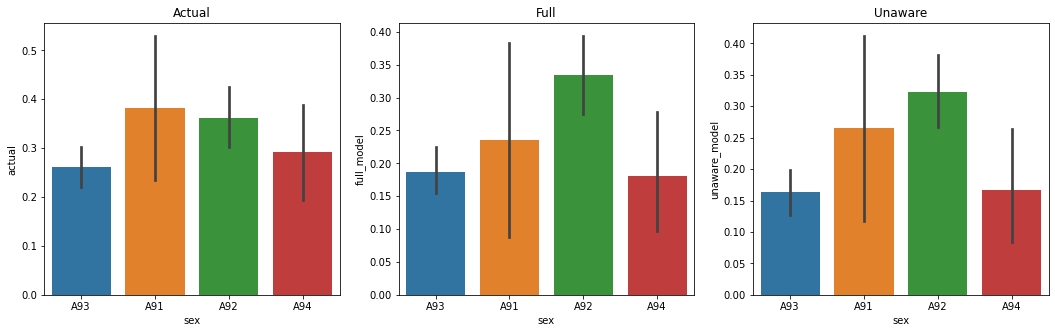

In [62]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize =(18, 5))
plt.subplot(1,3,1)
sns.barplot(x = 'sex', y = 'actual', data = result)
plt.title('Actual')

plt.subplot(1,3,2)
sns.barplot(x = 'sex', y = 'full_model', data = result)
plt.title('Full')

plt.subplot(1,3,3)
sns.barplot(x = 'sex', y = 'unaware_model', data = result)
plt.title('Unaware')

plt.show()

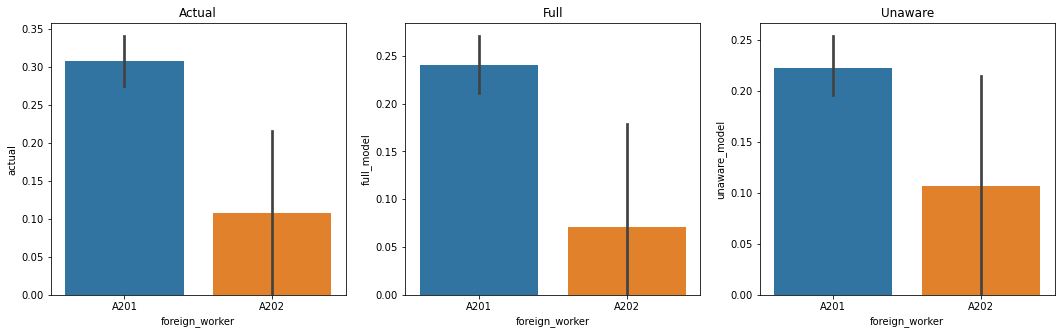

In [63]:
plt.figure(figsize =(18, 5))
plt.subplot(1,3,1)
sns.barplot(x = 'foreign_worker', y = 'actual', data = result)
plt.title('Actual')

plt.subplot(1,3,2)
sns.barplot(x = 'foreign_worker', y = 'full_model', data = result)
plt.title('Full')

plt.subplot(1,3,3)
sns.barplot(x = 'foreign_worker', y = 'unaware_model', data = result)
plt.title('Unaware')

plt.show()

In [65]:
result_test = pd.DataFrame({
    'sex': np.array(X_test_f['status_sex']),
    'foreign_worker': np.array(X_test_f['foreign_worker']),
    'actual': y_test_f,
    'full_model': pipe.predict(X_test_f),
    'unaware_model': _pipe.predict(_X_test)
})

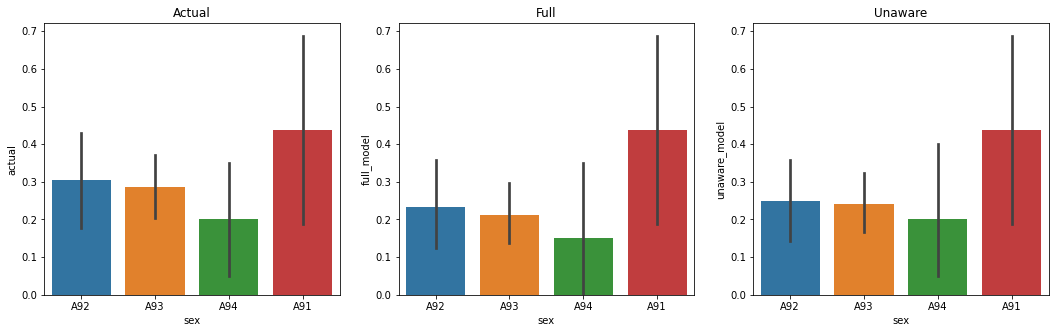

In [66]:
plt.figure(figsize =(18, 5))
plt.subplot(1,3,1)
sns.barplot(x = 'sex', y = 'actual', data = result_test)
plt.title('Actual')

plt.subplot(1,3,2)
sns.barplot(x = 'sex', y = 'full_model', data = result_test)
plt.title('Full')

plt.subplot(1,3,3)
sns.barplot(x = 'sex', y = 'unaware_model', data = result_test)
plt.title('Unaware')

plt.show()

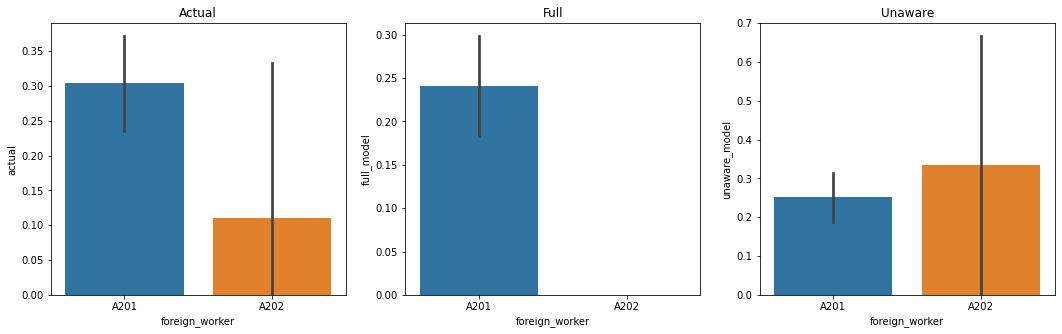

In [67]:
plt.figure(figsize =(18, 5))
plt.subplot(1,3,1)
sns.barplot(x = 'foreign_worker', y = 'actual', data = result_test)
plt.title('Actual')

plt.subplot(1,3,2)
sns.barplot(x = 'foreign_worker', y = 'full_model', data = result_test)
plt.title('Full')

plt.subplot(1,3,3)
sns.barplot(x = 'foreign_worker', y = 'unaware_model', data = result_test)
plt.title('Unaware')

plt.show()